Kayla Johnston  
GEOG 479 - GIS Programming  
Fall 2021  
Semester Project

# Estimating Live Fuel Moisture in Sagebrush Steppe with Satelitte Imagery  
Wildland live fuel moisture content is a critical element for estimating wildland fire risk, behavior, severity, and burning index. These estimated variables inform decisions on pre-position staffing of resources and wildland fire supression tactics. Accurate and reliable monitoring of wildland live fuel moisture content is necessary for successful and efficient wildland fire management.  

Current methods for monitoring wildland live fuel moistures require technicians to make field visits to gather vegetation samples, dry samples for up to 24 hours, and then calculate moisture content. This equates to nearly 2 days worth of work for point data meant to represent and inform the management of large, and often diverse, landscapes. This monitoring is typically completed every two weeks or less frequently as technicians are pulled into other tasks/roles. While this process "works", a better solution may be possible.  

We may be able to estimate and monitor wildland live fuel moisture content using satelitte imagery. If a reliable model could be derived from satelitte imagery, we would be able to estimate live fuel moisture content for the entire landscape in raster format, every 3-5 days, with only a few mouse clicks - improving efficiency and temporal and spatial resolution of live fuel moisture estimates.

# Project Goal
The goal of this project is to:  
* Explore NDWI, NDVI, MSI and their trends from April-September 2021 in south-central Idaho, comparing and contrasting these indexes calculated from Sentinel-2 vs LandSat 8 satelittes.

The project goal is a piece to the larger goal for a chapter of my dissertation:

Dissertation Chapter 3 Goal
* Create a regression model for estimating live fuel moisture content with inputs: live fuel moisture data collected during the summer of 2021, NDWI, NDVI, MSI, other remote sensing products (cover, biomass, etc.), and Sentinel 2 satelitte imagery bands.

# Data Used
* Sentinel-2 satelitte images from April-September 2021 (Google Earth Engine)
* LandSat 8 satelitte images from April-September 2021 (Google Earth Engine)
* Fuel moisture monitoring plot coordinates (personal file)

For the next step in the process of accomplishing the dissertation chapter 3 goal:
* NDWI, NDVI, MSI (outputs from Sentinel 2 images)
* Vegetation Biomass (Rangeland Analysis Platform, Google Earth Engine)
* Vegetation Cover (Rangeland Analysis Platform, Google Earth Engine)
* Topography - Aspect, Elevation, Slope (LandFire, Google Earth Engine) 
* Fuel moisture content values & coordinates measured during summer 2021 (personal file)

In [194]:
import ee 
import geemap
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [195]:
ee.Initialize() 
#the 'ee' python API must be verified (the first time it is used) and 
# initialized (each time it is imported/used)

# Goal One: NDWI, NDVI, & MSI

Define start and end dates for analysis.

In [196]:
startdate = '2021-04-01' #defines start date as a string object
enddate = '2021-09-30' #defines end date as a string object

Define area of interest by long, lat corners surrounding south-central Idaho and create polygon called 'aoi'.

In [197]:
coords = [[-115.633169, 42.531827],
            [-114.151440, 42.531827],
            [-114.151440, 43.011677],
            [-115.633169, 43.011677],
            [-115.633169, 42.531827]] #creates list object of coordinates defining the area of interest
aoi = ee.Geometry.Polygon(coords) #creates polygon geometry object using the list object 'coords'

Pull in Sentinel 2 image collection clipped to south-central Idaho (AOI) for April - September 2021, filter out images with greater than 20% cloud cover, and sort by ascending date. Correct for band scale.

Info on image collection used: 

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR?hl=en

In [198]:
# Code adapted from https://bikeshbade.com.np/tutorials/Detail/?title=Calculate%20NDVI%20from%20Sentinel-2%20%20with%20Python%20API&code=18

inBands = ee.List(['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']) 
#creates a list object of current band names
outBands = ee.List(['QA60','blue','green','red','B5','B6','B7','nir', 'B8A', 'water vapor','swir1','swir2'])
#creates a list object of desired band names
 
CloudCoverMax = 30 #creates an integer object to use as maximum desired cloud cover, filtering out cloudy images

#sets up a function to import Sentinel-2 data, correct for scale, and rename the bands
#function takes an area of interest, start date, and end date
def importData(aoi,startdate,enddate): 
 
    # Get Sentinel-2 data
    S2_SR_aoi =(ee.ImageCollection('COPERNICUS/S2_SR') #pull google earth engine image collection and assign it to this object
          .filterDate(ee.Date(startdate), ee.Date(enddate)) #filters image collection to specified date range
          .filterBounds(aoi) #filters image collection to specified area of interest
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CloudCoverMax)) #filters out images with >20% cloudy pixels
          .filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT',CloudCoverMax)) #filters out images >20% cloud cover 
          .sort('system:time_start')) #sorts the imported collection by ascending date
    
    #sets up function within parent function to rescale bands
    def scaleBands(img):
        prop = img.toDictionary() #extracts properties from an image as a dictionary
        t = (img.select(['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']).multiply(0.0001)) 
        #selects specified bands from an image and corrects for scale, sentinel bands are in scale of 0.0001
        t = (t.addBands(img.select(['QA60']))
            .set(prop)
            .copyProperties(img,['system:time_start','system:footprint']))
        #adds time start and location properties back into the image
        #ee.image.set = overrides one or more metadata properties of an element, give dictionary or sequence
        #.copyProperties pulls selected properties from given element and copies to output element
        return ee.Image(t) #returns the rescaled image
    
    
    S2_SR_aoi = S2_SR_aoi.map(scaleBands) #runs the rescale bands function on the imported image collection
    #.map applies the function to each image in the collection
    S2_SR_aoi = S2_SR_aoi.select(inBands,outBands) #selects bands matching 'inBands' and renames them corresponding to values in 'outBands'
    
    return S2_SR_aoi #returns the Sentinel-2 image collection, corrected for scale, and with bands renamed

In [199]:
s2 = importData(aoi, startdate, enddate) #runs the above function using previously defined objects

In [200]:
# function to reproject an ee image
def project_IC(image):
    return image.reproject('EPSG: 4326')

In [201]:
# map the reproject function over image collection
s2 = s2.map(project_IC)

Pull in LandSat 8 image collection clipped to south-central Idaho (AOI) for April - September 2021 and sort by ascending date. Correct for band scale. *When filtering out by any percent cloud cover, returned zero images.

Info on image collection used:

https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2

In [202]:
# Code adapted from https://bikeshbade.com.np/tutorials/Detail/?title=Calculate%20NDVI%20from%20Sentinel-2%20%20with%20Python%20API&code=18

inBandsLS = ee.List(['QA_PIXEL','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'])
#creates a list object of current band names
outBandsLS = ee.List(['QA_PIXEL','blue','green','red','nir','swir1','swir2'])
#creates a list object of desired band names

#sets up a function to import Sentinel-2 data, correct for scale, and rename the bands
#function takes an area of interest, start date, and end date
def importDataLS(aoi,startdate,enddate):
 
    # Get LandSat 8 data
    LS_SR_aoi =(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
          .filterDate(ee.Date(startdate), ee.Date(enddate))
          .filterBounds(aoi)
          .sort('system:time_start'))
    
    #sets up function within parent function to rescale bands
    def scaleBandsLS(img):
        prop = img.toDictionary() #extracts properties from an image as a dictionary
        t = (img.select(['QA_PIXEL','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']).multiply(0.0000275))
        #selects specified bands from an image and corrects for scale, landsat bands are in scale of 2.75e-05
        t = (t.addBands(img.select(['QA_PIXEL']))
            .set(prop)
            .copyProperties(img,['system:time_start','system:footprint']))
        #adds time start and location properties back into the image
        #ee.image.set = overrides one or more metadata properties of an element, give dictionary or sequence
        #.copyProperties pulls selected properties from given element and copies to output element
        return ee.Image(t) #returns the rescaled image
    
    
    LS_SR_aoi = LS_SR_aoi.map(scaleBandsLS)#runs the rescale bands function on the imported image collection
    #.map applies the function to each image in the collection
    LS_SR_aoi = LS_SR_aoi.select(inBandsLS,outBandsLS) #selects bands matching 'inBands' and renames them corresponding to values in 'outBands'
    
    return LS_SR_aoi #returns the LandSat 8 image collection, corrected for scale, and with bands renamed

In [203]:
ls8 = importDataLS(aoi, startdate, enddate) #runs the above function using previously defined objects, returns image collection

In [204]:
# map the reproject function over image collection
ls8 = ls8.map(project_IC)

## Calculate NDWI for each image in satelitte image collections
* NDWI = (NIR - SWIR) / (NIR + SWIR)
* NDWI ranges from -1 to 1, higher values corresponding to higher water content.
* NDWI for S2 = (nir - swir2) / (nir + swir2) 
* NDWI for LS 8 = (nir - swir1) / (nir + swir1)

Define function to calculate NDWI for Sentinel-2, use "map" method to apply the function to every image in the collection.

In [205]:
#sets up a function with the goal of calculating NDWI for a Sentinel-2 image and adding a NDWI band to the image
def s2_addNDWI(image): 
    ndwi = image.normalizedDifference(['nir', 'swir2']).rename('NDWI') #calculates NDWI for the image
    return image.addBands(ndwi) #adds ndwi band to image and returns image
    
s2 = s2.map(s2_addNDWI) # this is applying the function to every image in the collection
print(s2.first().bandNames().getInfo()) #prints the band names for the first image in the collection to ensure ndwi was added

['QA60', 'blue', 'green', 'red', 'B5', 'B6', 'B7', 'nir', 'B8A', 'water vapor', 'swir1', 'swir2', 'NDWI']


Define function to calculate NDWI for LandSat 8, use "map" method to apply the function to every image in the collection.

In [206]:
#sets up a function with the goal of calculating NDWI for a LandSat 8 image and adding a NDWI band to the image
def ls8_addNDWI(image):
    ndwi = image.normalizedDifference(['nir', 'swir1']).rename('NDWI') #calculates NDWI for the image
    return image.addBands(ndwi) #adds ndwi band to image and returns image
    
ls8 = ls8.map(s2_addNDWI) # this is applying the function to every image in the collection
print(ls8.first().bandNames().getInfo()) #prints the band names for the first image in the collection to ensure ndwi was added

['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'NDWI']


## Calculate NDVI for each image in satelitte image collections
* NDVI = (NIR - Red) + (NIR + Red)
* NDVI ranges from -1 to 1, higher values corresponding to "healthier" vegetation
* NDVI for S2 = (nir - red) / (nir + red)
* NDVI for LS 8 = (nir - red) / (nir + red)

Define function to calculate NDVI for Sentinel-2 and LandSat 8, use "map" method to apply the function to every image in the collection.

In [207]:
#sets up a function with the goal of calculating NDVI for an image and adding a NDVI band to the image
def addNDVI(image):
    ndvi = image.normalizedDifference(['nir', 'red']).rename('NDVI') #calculates NDVI
    return image.addBands(ndvi) #adds ndvi band to image and returns image
    
s2 = s2.map(addNDVI) #this is applying the function to every image in the collection
ls8 = ls8.map(addNDVI) #this is applying the function to every image in the collection
print(s2.first().bandNames().getInfo()) #prints band names in first image of collection
print(ls8.first().bandNames().getInfo()) #prints band names in first image of collection

['QA60', 'blue', 'green', 'red', 'B5', 'B6', 'B7', 'nir', 'B8A', 'water vapor', 'swir1', 'swir2', 'NDWI', 'NDVI']
['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'NDWI', 'NDVI']


## Calculate MSI for each image in satelitte image collections
* MSI = SWIR/NIR
* MSI ranges from 0 to over 3, green vegetation typically ranges from 0.2 - 2.9 or 0.4-2.0
* MSI for S2 = swir1/nir
* MSI for LandSat 8 = swir1/nir

Define function to calculate MSI for Sentinel-2 & LandSat 8, use "map" method to apply the function to every image in the collection.

In [208]:
#sets up a function with the goal of calculating MSI for an image and adding a MSI band to the image
def addMSI(image):
    swir1 = image.select('swir1') #selects the swir1 band from the image and assigns it to an object
    nir = image.select('nir') #selects the nir band from the image and assigns it to an object
    msi = swir1.divide(nir).rename('MSI') #calculates MSI
    return image.addBands(msi) #adds msi band to image and returns image
    
s2 = s2.map(addMSI) #this is applying the function to every image in the collection
ls8 = ls8.map(addMSI) #this is applying the function to every image in the collection
print(s2.first().bandNames().getInfo()) #prints band names in first image of collection
print(ls8.first().bandNames().getInfo()) #prints band names in first image of collection

['QA60', 'blue', 'green', 'red', 'B5', 'B6', 'B7', 'nir', 'B8A', 'water vapor', 'swir1', 'swir2', 'NDWI', 'NDVI', 'MSI']
['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'NDWI', 'NDVI', 'MSI']


## Plot NDWI, NDVI, and MSI trend for 24 plots for each satelitte.

Pull in shapefile of fuel moisture monitoring plots and buffer plot center coordinates.

In [209]:
# pull in shapefile and converts to ee feature collection, shapefile must be in epsg 4326
FMplots_eeFC = geemap.shp_to_ee('C:/Users/kayla/GIS_programming_F21/Project/S2_COORDS3.shp')

In [210]:
# function to buffer feature
def buff_FC(feature):
    buffer_radius = 17.84
    return feature.buffer(buffer_radius)

In [211]:
# map buffer function over feature collection
fmPlots_fcbuff = FMplots_eeFC.map(buff_FC)

Calculate zonal statistic of each index for each plot in each image.

In [217]:
output_dir = os.path.join(os.path.expanduser('~'), 'GIS_programming_F21/Project/Outputs') # creates output directory
s2_out = os.path.join(output_dir, 's2_plot_means.csv') # creates an empty output file
ls8_out = os.path.join(output_dir, 'ls8_plot_means.csv') # creates an empty output file

In [218]:
# calculates zonal mean for within the buffered plot centers and sends to results to the specified output file
geemap.zonal_statistics(s2, fmPlots_fcbuff, s2_out, statistics_type='MEAN', scale=20)
geemap.zonal_statistics(ls8, fmPlots_fcbuff, ls8_out, statistics_type='MEAN', scale=20)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\kayla\GIS_programming_F21\Project\Outputs\ls8_plot_means.csv


Plot for each index from Sentinel-2.

In [221]:
# read ee output into pandas - no more ee!!!
data_pd = pd.read_csv('C:/Users/kayla/GIS_programming_F21/Project/Outputs/s2_plot_means.csv')

# turn "wide" dataframe into "long" dataframe
data_pd = pd.melt(data_pd, id_vars=['Plot_num', 'Plot_type'])

# remove 'system:index' variable, meaningless
data_pd = data_pd.loc[data_pd['variable'] != 'system:index']

# parse the date out of variable column and save as categorical 
data_pd['date'] = pd.Categorical(data_pd['variable'].apply(lambda x: x[4:8]))

# parse the band out of variable column
data_pd['band'] = data_pd['variable'].apply(lambda x: x.split('_')[-1])

# parse the grid  system (surrogate for sensor - S2A vs S2B) 
data_pd['grid'] = data_pd['variable'].apply(lambda x: x.split('_')[-2][-3:])

# bands  we care about 
data_pd = data_pd.query("band == 'NDVI' | band ==  'NDWI' | band ==  'MSI'")

data_pd['band'].value_counts()

NDWI    2280
NDVI    2280
MSI     2280
Name: band, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

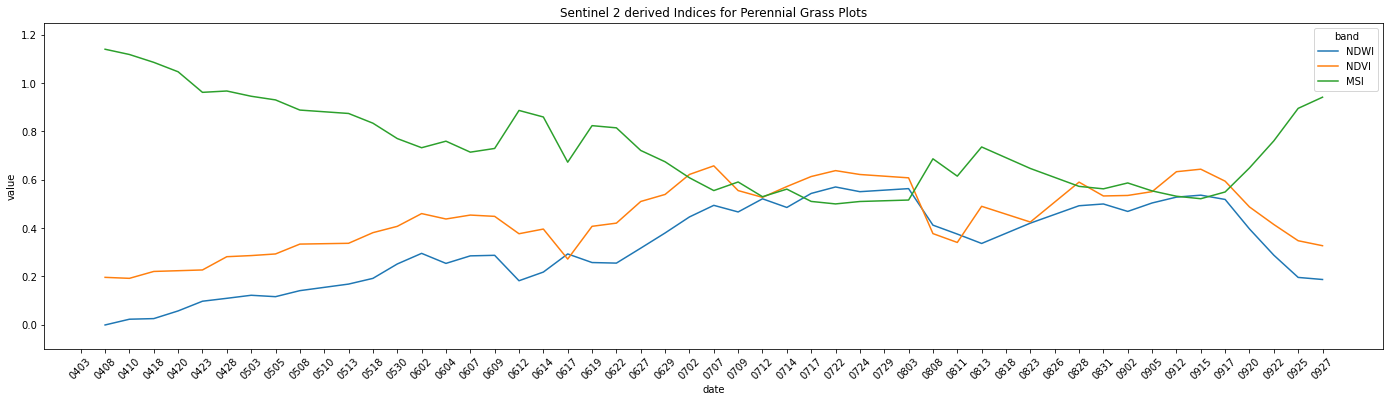

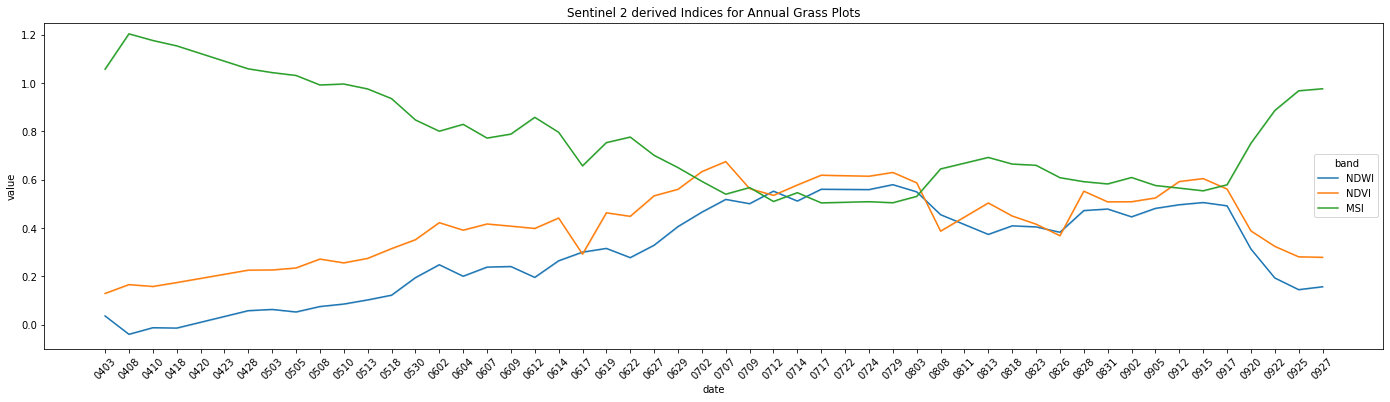

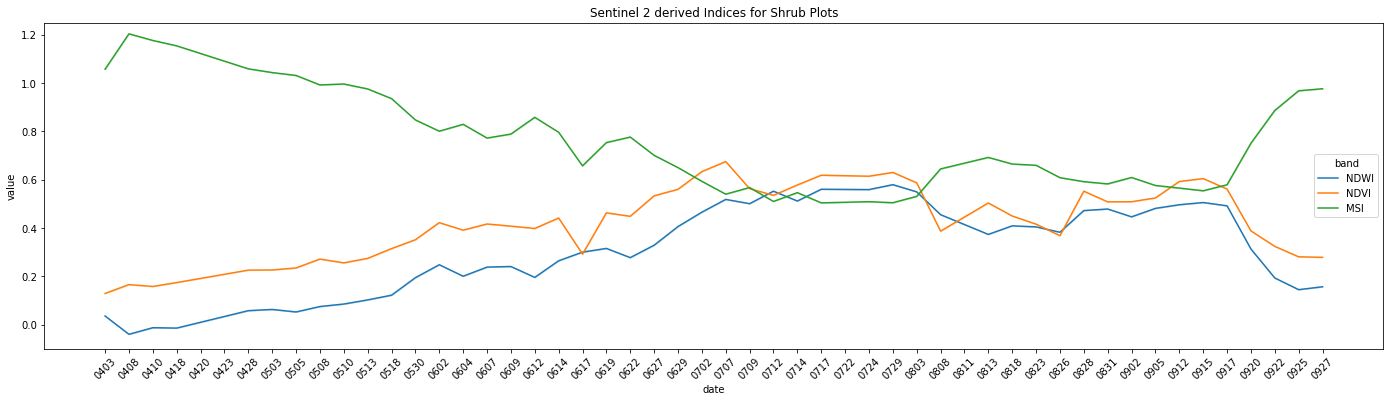

In [223]:
ylims = (-0.1, 1.25) # object containing desired y-axis limits

# TQH for HP plots
s2_TQH = data_pd.loc[data_pd['grid'] == 'TQH'] # pulls out data collected by particular sensor 
df_TQH=s2_TQH

df_TQH = df_TQH[df_TQH['Plot_type'] == 'HP'] # pulls out just HP plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=df_TQH, x='date', y='value', hue='band', ci=None) # sends data to line plot
ax.set(title='Sentinel 2 derived Indices for Perennial Grass Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

# TPH for HA plots
s2_TPH = data_pd.loc[data_pd['grid'] == 'TPH'] # pulls out data collected by particular sensor 
df_TPH=s2_TPH

df_TPH = df_TPH[df_TPH['Plot_type'] == 'HA'] # pulls out just HA plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=df_TPH, x='date', y='value', hue='band') # sends data to line plot
ax.set(title='Sentinel 2 derived Indices for Annual Grass Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

# TPH for HS plots
s2_TPH = data_pd.loc[data_pd['grid'] == 'TPH'] # pulls out data collected by particular sensor 
df_TPH=s2_TPH

df_TPH = df_TPH[df_TPH['Plot_type'] == 'HS'] # pulls out just HS plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=df_TPH, x='date', y='value', hue='band') # sends data to line plot
ax.set(title='Sentinel 2 derived Indices for Shrub Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

Plot for each index from LandSat 8.

In [219]:
# read ee output into pandas - no more ee!!!
datals8_pd = pd.read_csv('C:/Users/kayla/GIS_programming_F21/Project/Outputs/ls8_plot_means.csv')

# turn "wide" dataframe into "long" dataframe
datals8_pd = pd.melt(datals8_pd, id_vars=['Plot_num', 'Plot_type'])

# remove 'system:index' variable, meaningless
datals8_pd = datals8_pd.loc[datals8_pd['variable'] != 'system:index']

# parse the date out of variable column and save as categorical 
datals8_pd['date'] = pd.Categorical(datals8_pd['variable'].apply(lambda x: x[16:20]))

# parse the band out of variable column
datals8_pd['band'] = datals8_pd['variable'].apply(lambda x: x.split('_')[-1])

# parse the grid  system (surrogate for sensor - S2A vs S2B) 
datals8_pd['grid'] = datals8_pd['variable'].apply(lambda x: x.split('_')[-3])

# bands we care about 
datals8_pd = datals8_pd.query("band == 'NDVI' | band ==  'NDWI' | band ==  'MSI'")

datals8_pd['band'].value_counts()

NDWI    1080
NDVI    1080
MSI     1080
Name: band, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

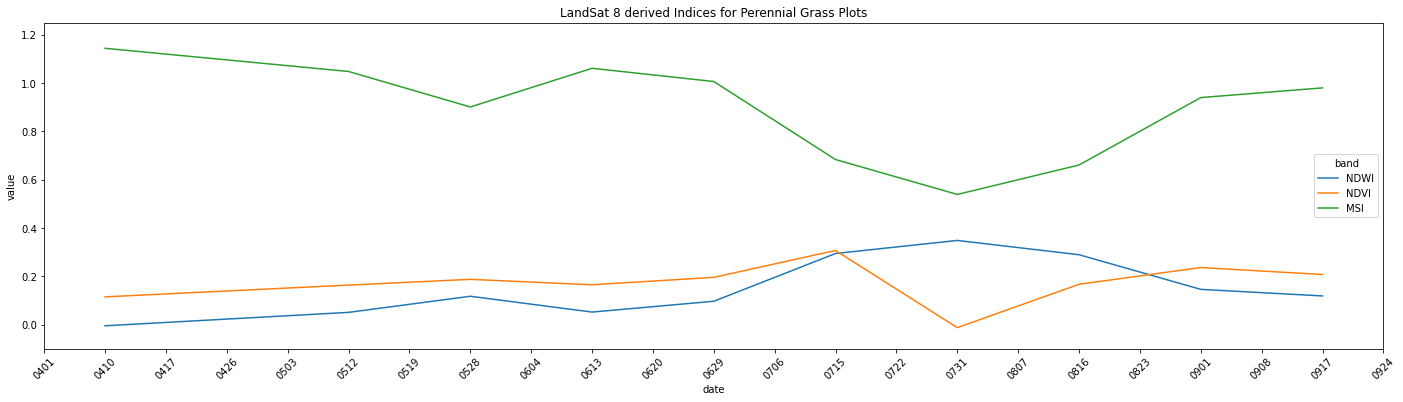

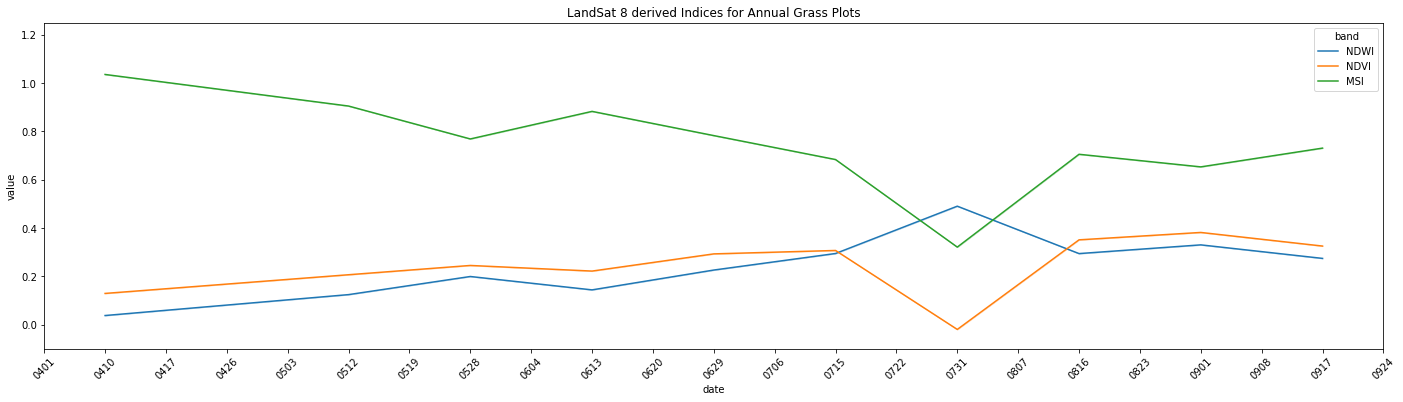

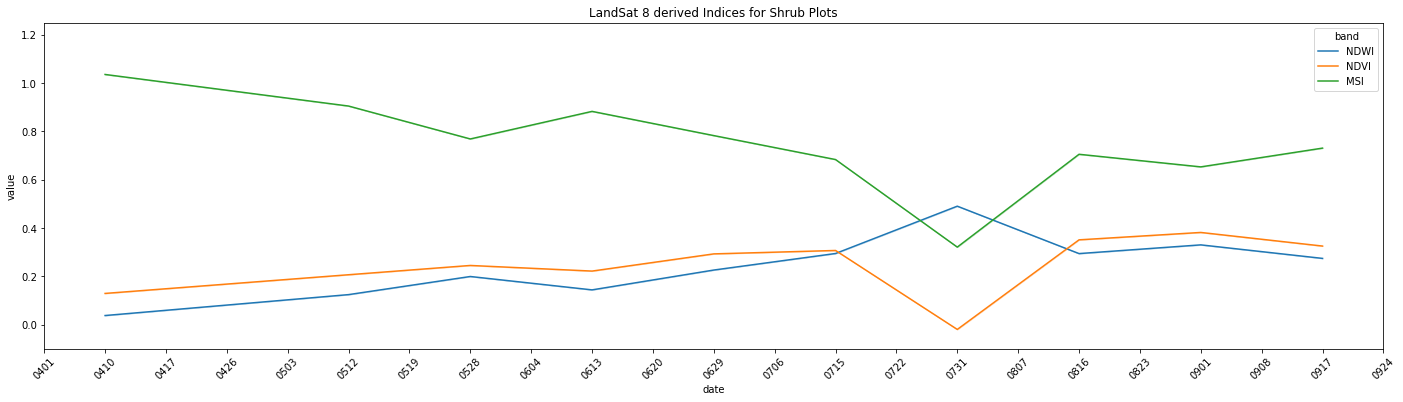

In [224]:
ylims = (-0.1, 1.25)

# 040031 for HP plots
ls8_040031 = datals8_pd.loc[datals8_pd['grid'] == '040031'] # pulls out data collected by particular sensor 
dfls8=ls8_040031

dfls8 = dfls8[dfls8['Plot_type'] == 'HP'] # pulls out just HP plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=dfls8, x='date', y='value', hue='band', ci=None) # sends data to line plot
ax.set(title='LandSat 8 derived Indices for Perennial Grass Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

# 040031 for HA plots
ls8_040031 = datals8_pd.loc[datals8_pd['grid'] == '040031'] # pulls out data collected by particular sensor 
dfls8=ls8_040031

dfls8 = dfls8[dfls8['Plot_type'] == 'HA'] # pulls out just HA plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=dfls8, x='date', y='value', hue='band') # sends data to line plot
ax.set(title='LandSat 8 derived Indices for Annual Grass Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

# 040031 for HS plots
ls8_040031 = datals8_pd.loc[datals8_pd['grid'] == '040031'] # pulls out data collected by particular sensor 
dfls8=ls8_040031

dfls8 = dfls8[dfls8['Plot_type'] == 'HS'] # pulls out just Hs plots
fig, ax = plt.subplots(figsize=(24,6)) # creates empty figure
sns.lineplot(ax=ax, data=dfls8, x='date', y='value', hue='band') # sends data to line plot
ax.set(title='LandSat 8 derived Indices for Shrub Plots') # sets plot title
plt.xticks(rotation=45) # rotates dates 45 degrees
plt.ylim(ylims) # sets y-axis limits
plt.show # displays plot

<img src="20211204_201505.jpg" width="400">

<img src="20211204_201503.jpg" width="400">